# Prepare

## import libraries

In [1]:
import os
import sys
import time
import random
import logging
import typing as tp
from pathlib import Path
from contextlib import contextmanager

from matplotlib import pyplot as plt
import seaborn as sns

import numpy as np
import pandas as pd

from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_log_error, mean_squared_error

import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoost, Pool

%matplotlib inline

## read data

In [2]:
ROOT = Path.cwd().parent
INPUT = ROOT / "input"
DATA = INPUT / "tabular-playground-series-jan-2021"
WORK = ROOT / "working"

for path in DATA.iterdir():
    print(path.name)

sample_submission.csv
train.csv
test.csv


In [3]:
train = pd.read_csv(DATA / "train.csv")
test = pd.read_csv(DATA / "test.csv")
smpl_sub = pd.read_csv(DATA / "sample_submission.csv")
print("train: {}, test: {}, sample sub: {}".format(
    train.shape, test.shape, smpl_sub.shape
))

train: (300000, 16), test: (200000, 15), sample sub: (200000, 2)


In [4]:
train.head().T

,0,1,2,3,4
id,1.000000,3.000000,4.000000,5.000000,8.000000
cont1,0.670390,0.388053,0.834950,0.820708,0.935278
cont2,0.811300,0.621104,0.227436,0.160155,0.421235
cont3,0.643968,0.686102,0.301584,0.546887,0.303801
cont4,0.291791,0.501149,0.293408,0.726104,0.880214
cont5,0.284117,0.643790,0.606839,0.282444,0.665610
cont6,0.855953,0.449805,0.829175,0.785108,0.830131
cont7,0.890700,0.510824,0.506143,0.752758,0.487113
cont8,0.285542,0.580748,0.558771,0.823267,0.604157
cont9,0.558245,0.418335,0.587603,0.574466,0.874658


## Definition

In [5]:
@contextmanager
def timer(logger=None, format_str='{:.3f}[s]', prefix=None, suffix=None):
    if prefix: format_str = str(prefix) + format_str
    if suffix: format_str = format_str + str(suffix)
    start = time.time()
    yield
    d = time.time() - start
    out_str = format_str.format(d)
    if logger:
        logger.info(out_str)
    else:
        print(out_str)

In [6]:
class TreeModel:
    """Wrapper for LightGBM/XGBoost/CATBoost"""
    def __init__(self, model_type: str):
        self.model_type = model_type
        self.trn_data = None
        self.val_data = None
        self.model = None

    def train(self,
              params: dict,
              X_train: pd.DataFrame, y_train: np.ndarray,
              X_val: pd.DataFrame, y_val: np.ndarray,
              train_weight: tp.Optional[np.ndarray] = None,
              val_weight: tp.Optional[np.ndarray] = None,
              train_params: dict = {}):
        if self.model_type == "lgb":
            self.trn_data = lgb.Dataset(X_train, label=y_train, weight=train_weight)
            self.val_data = lgb.Dataset(X_val, label=y_val, weight=val_weight)
            self.model = lgb.train(params=params,
                                   train_set=self.trn_data,
                                   valid_sets=[self.trn_data, self.val_data],
                                   **train_params)
        elif self.model_type == "xgb":
            self.trn_data = xgb.DMatrix(X_train, y_train, weight=train_weight)
            self.val_data = xgb.DMatrix(X_val, y_val, weight=val_weight)
            self.model = xgb.train(params=params,
                                   dtrain=self.trn_data,
                                   evals=[(self.trn_data, "train"), (self.val_data, "val")],
                                   **train_params)
        elif self.model_type == "cat":
            self.trn_data = Pool(X_train, label=y_train, group_id=[0] * len(X_train))
            self.val_data =  Pool(X_val, label=y_val, group_id=[0] * len(X_val))
            self.model = CatBoost(params)
            self.model.fit(
                self.trn_data, eval_set=[self.val_data], use_best_model=True, **train_params)
        else:
            raise NotImplementedError

    def predict(self, X: pd.DataFrame):
        if self.model_type == "lgb":
            return self.model.predict(
                X, num_iteration=self.model.best_iteration)  # type: ignore
        elif self.model_type == "xgb":
            X_DM = xgb.DMatrix(X)
            return self.model.predict(
                X_DM, ntree_limit=self.model.best_ntree_limit)  # type: ignore
        elif self.model_type == "cat":
            return self.model.predict(X)
        else:
            raise NotImplementedError

    @property
    def feature_names_(self):
        if self.model_type == "lgb":
            return self.model.feature_name()
        elif self.model_type == "xgb":
            return list(self.model.get_score(importance_type="gain").keys())
        elif self.model_type == "cat":
             return self.model.feature_names_
        else:
            raise NotImplementedError

    @property
    def feature_importances_(self):
        if self.model_type == "lgb":
            return self.model.feature_importance(importance_type="gain")
        elif self.model_type == "xgb":
            return list(self.model.get_score(importance_type="gain").values())
        elif self.model_type == "cat":
            return self.model.feature_importances_
        else:
            raise NotImplementedError

# Training & Inference

## Config 

In [7]:
ID_COL = "id"
FEAT_COLS = [f"cont{i}" for i in range(1, 15)]
TGT_COL = "target"

N_SPLITS =10# 5
RANDOM_SEED =190295 #999#422021,
USE_MODEL = "lgb"

MODEL_PARAMS = {
  
 "seed": RANDOM_SEED,
'objective': 'regression',
 'metric': 'rmse',
 'verbosity': -1,
 'feature_pre_filter': False,
 'lambda_l1': 6.540486456085813,
 'lambda_l2': 0.01548480538099245,
 'num_leaves': 256,
 'feature_fraction': 0.52,
 'bagging_fraction': 0.6161835249194311,
 'bagging_freq': 7,
 'min_child_samples': 20,
'learning_rate': 0.001,
"boosting_type": "gbdt",
}

#  "metric": 'rmse',
# "bagging_seed": 11,
# "verbosity": -1,
# 'reg_alpha': 0.3899927210061127,
# 'reg_lambda': 0.6485237330340494,
# 'lambda_l1': 1.074622455507616e-05,
# 'lambda_l2': 2.0521330798729704e-06,
#}
TRAIN_PARAMS = {
    "num_boost_round": 90000,
    "early_stopping_rounds": 1000,
    "verbose_eval": 100,
}

## Prepare Data

In [8]:
X = train[FEAT_COLS]
X_test = test[FEAT_COLS]

y = train[TGT_COL].values

kf = KFold(n_splits=N_SPLITS, shuffle=True, random_state=RANDOM_SEED)
trn_val_indexs = list(kf.split(X, y))

## Training

In [9]:
oof_pred_arr = np.zeros(len(X))
test_preds_arr = np.zeros((N_SPLITS, len(X_test)))
feature_importances = pd.DataFrame()
score_list = []

In [10]:
for fold, (trn_idx, val_idx) in enumerate(trn_val_indexs):
    print("*" * 100)
    print(f"Fold: {fold}")

    X_trn = X.loc[trn_idx].reset_index(drop=True)
    X_val = X.loc[val_idx].reset_index(drop=True)
    y_trn = y[trn_idx]
    y_val = y[val_idx]

    model = TreeModel(model_type=USE_MODEL)
    with timer(prefix="Model training"):
        model.train(
            params=MODEL_PARAMS, X_train=X_trn, y_train=y_trn,
            X_val=X_val, y_val=y_val, train_params=TRAIN_PARAMS)
    fi_tmp = pd.DataFrame()
    fi_tmp["feature"] = model.feature_names_
    fi_tmp["importance"] = model.feature_importances_
    fi_tmp["fold"] = fold
    feature_importances = feature_importances.append(fi_tmp)

    val_pred = model.predict(X_val)
    score = mean_squared_error(y_val, val_pred, squared=False)

    print(f"score: {score:.5f}")
    score_list.append([fold, score])
    oof_pred_arr[val_idx] = val_pred
    test_pred = model.predict(X_test)
    test_preds_arr[fold] = test_pred

****************************************************************************************************
Fold: 0
Training until validation scores don't improve for 1000 rounds
[100]	training's rmse: 0.729747	valid_1's rmse: 0.731381
[200]	training's rmse: 0.726848	valid_1's rmse: 0.728985
[300]	training's rmse: 0.724166	valid_1's rmse: 0.726785
[400]	training's rmse: 0.721724	valid_1's rmse: 0.724833
[500]	training's rmse: 0.71946	valid_1's rmse: 0.723057
[600]	training's rmse: 0.717369	valid_1's rmse: 0.721439
[700]	training's rmse: 0.71542	valid_1's rmse: 0.719959
[800]	training's rmse: 0.713608	valid_1's rmse: 0.718612
[900]	training's rmse: 0.711911	valid_1's rmse: 0.717388
[1000]	training's rmse: 0.710327	valid_1's rmse: 0.716254
[1100]	training's rmse: 0.708834	valid_1's rmse: 0.715204
[1200]	training's rmse: 0.707423	valid_1's rmse: 0.714245
[1300]	training's rmse: 0.706105	valid_1's rmse: 0.713368
[1400]	training's rmse: 0.70484	valid_1's rmse: 0.712536
[1500]	training's rmse: 0.70

## Check Result

### score of each fold and oof

In [11]:
oof_score = mean_squared_error(y, oof_pred_arr, squared=False)
score_list.append(["oof", oof_score])
pd.DataFrame(
    score_list, columns=["fold", "rmse score"])

,fold,rmse score
0,0,0.696398
1,1,0.691391
2,2,0.695421
3,3,0.695934
4,4,0.695141
5,5,0.694826
6,6,0.693735
7,7,0.697676
8,8,0.696245
9,9,0.694489


### feature importance

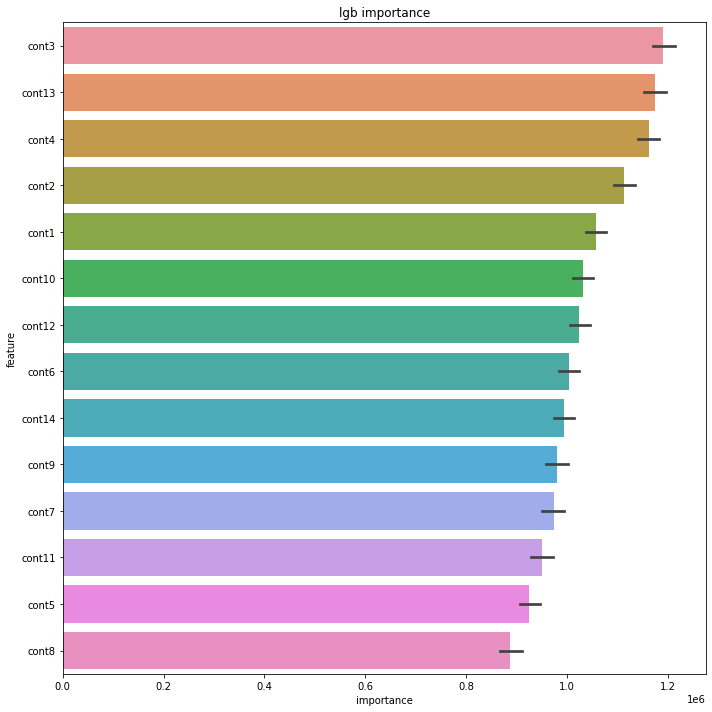

In [12]:
order = list(feature_importances.groupby("feature").mean().sort_values("importance", ascending=False).index)
plt.figure(figsize=(10, 10))
sns.barplot(x="importance", y="feature", data=feature_importances, order=order)
plt.title("{} importance".format(USE_MODEL))
plt.tight_layout()

## Make submission

In [13]:
smpl_sub.head()

,id,target
0,0,0.5
1,2,0.5
2,6,0.5
3,7,0.5
4,10,0.5


In [14]:
sub = smpl_sub.copy()
sub[TGT_COL] = test_preds_arr.mean(axis=0)

sub.to_csv("submission.csv", index=False)

sub.head()

,id,target
0,0,7.915049
1,2,7.885623
2,6,7.936237
3,7,8.291335
4,10,8.100499
